<h1 align=center><font size = 4>Segmenting and Clustering Neighborhoods in Toronto</font></h1>

<font size = 3>**Part3: Explore and cluster the neighborhoods in Toronto**</font>

**Download all the dependencies that we will need**

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you don't have it 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes  # uncomment this line if you don't have it 
import folium # map rendering library

### 1.  Dataset

**Import dataset from part 2**

In [2]:
dataset = pd.read_csv('merged.postal.codes.toronto.csv', header=0)
print(dataset.shape)

dataset.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


To cluster neighborhoods in Toronto, I further divided **Neighborhood** column in the data set: one neignborhood per row. Details of how I make a final data set are below: 

<details><summary>Click here for view the details</summary>

```python
df = []
for i in range(dataset.shape[0]):
    neigh = dataset.loc[i, 'Neighborhood'].split(', ')
    row = tuple(dataset.iloc[i]) 
    if len(neigh)==1:
        df.append(row)
    else:
        for j in range(len(neigh)):
            try:
                address = '{}, {}, CA'.format(neigh[j],
                                'Toronto' if 'Toronto' in row[1] else row[1])
                # convert an address into latitude and longitude values
                geolocator = Nominatim(user_agent="to_explorer") 
                location = geolocator.geocode(address)
                df.append((row[0], row[1], neigh[j],
                           location.latitude, location.longitude))
            except:
                df.append((row[0], row[1], neigh[j], 0, 0))
df = pd.DataFrame(df, columns = dataset.columns)

# handled entries separately with which geopy library couldn't deal
zindx = df[df['Latitude'] == 0].index
df.loc[zindx,['PostalCode', 'Borough', 'Neighborhood']]    
zll = [(43.662301, -79.389494),
       (43.67, -79.546),
       (43.673406, -79.56081),
       (43.6437, -79.5767),
       (43.7576403028, -79.4537931848),
       (43.77333024, -79.33999864),
       (43.6815, -79.4668),
       (43.6815, -79.4668),
       (43.6815, -79.4668),
       (43.6705, -79.3901),
       (43.6426, -79.3871),
       (43.623164174, -79.390998436),
       (43.620543, -79.47793),
       (43.7323, -79.6572),
       (43.7426, -79.5750),
       (43.7395, -79.5591),
       (43.7804, -79.2505),
       (43.6627, -79.3216),
       (43.6288, -79.5210)
      ]
df.loc[zindx,['Latitude', 'Longitude']] = zll

# correct wrongly recorded entries    
corr1 = df[df['Neighborhood'] == 'Richmond'].index
corr2 = df[df['Neighborhood'] == 'Parkview Hill'].index
df.loc[corr1, ['Latitude', 'Longitude']] = (43.651464545, -79.379639289) 
df.loc[corr2, ['Latitude', 'Longitude']] = (43.7082, -79.3170)
```
</details>

You don't need to execute the code above. Transformed data can be imported below.

**Import transformed dataset: one neignborhood per row**

In [3]:
df = pd.read_csv('finaldf.csv', header=0)
print(df.shape)

df.head()

(217, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457
3,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150
4,M6A,North York,Lawrence Manor,43.722079,-79.437507


**Explore venues near neighborhood using FourSquare API**

FourSquare API Credentials

In [ ]:
CLIENT_ID = ' ' # your Foursquare ID
CLIENT_SECRET = ' ' # your Foursquare Secret
ACCESS_TOKEN = ' ' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 70 # Foursquare API limit value

Function to get nearby venues within radius 500 meters from FourSquare API

In [ ]:
def getNearbyVenues(postalcode, bor, neigh, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pc, borough, neighborhood, lat, lng in zip(postalcode, bor, neigh, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pc,
            borough,
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 'Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Extract venue information from FourSquare API

In [4]:
#venues = getNearbyVenues(postalcode = df['PostalCode'],
#                         bor =df['Borough'],
#                         neigh = df['Neighborhood'],
#                         latitudes=df['Latitude'],
#                         longitudes=df['Longitude'])
#Since it takes a little time to get the result from the code above,
#I saved the result as a csv file. To import it, uncomment the code below.
venues = pd.read_csv('venues.by.neigh.csv', header=0)
print(venues.shape)

venues.head()

(6426, 9)


,PostalCode,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,North York,Parkwoods,43.753259,-79.329656,Careful & Reliable Painting,43.752622,-79.331957,Construction & Landscaping
2,M3A,North York,Parkwoods,43.753259,-79.329656,649 Variety,43.754513,-79.331942,Convenience Store
3,M3A,North York,Parkwoods,43.753259,-79.329656,Towns On The Ravine,43.754754,-79.332552,Hotel
4,M3A,North York,Parkwoods,43.753259,-79.329656,Sun Life,43.754760,-79.332783,Construction & Landscaping


In [5]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 365 unique categories.


There are too many catagories which might cause issues when using K-means (distance based methods) to cluster neighborhood in Toronto. When I looked into them, some of them seem to be overlapped. So, I made a new column called **cat** and organized them. Details of how I organized them are below:


<details><summary>Click here for view the details</summary>

```python
Bus = '|'.join(['Bus Stop', 'Light Rail Station', 'Bus Line', 'Bus Station'])
Office = '|'.join(['Business Center', 'Lawyer', 'Business Service', 
                   'Financial or Legal Service','Bank', 'IT Services', 
                   'Insurance Office', 'General Travel'])
Automotive = '|'.join(['Motorcycle Shop', 'Auto Workshop','Gas Station', 
                       'Rental Car Location', 'Auto Garage'])                 
Othershop = '|'.join(['Thrift / Vintage Store', 'Flower Shop',
                      'Gift Shop','Mattress Store','Optical Shop',
                      'Antique Shop', 'Watch Shop', 'Mobile Phone Shop',
                      'Luggage Store','Shop & Service', 'Print Shop',
                      'Bath House', 'Electronics Store',
                      'Discount Store','Gaming Cafe','Other Repair Shop',
                      'Locksmith'])
ShipMail = '|'.join(['Shipping Store', 'Post Office'])
Medical = '|'.join(['Pharmacy', 'Medical Center', "Doctor's Office", 
                    'Medical Supply Store', 'Drugstore'])
Dessert = '|'.join(['Café', 'Coffee','Juice', 'Bubble Tea', 'Smoothie',
                    'Frozen Yogurt','Chocolate', 'Creperie','Donut Shop',
                    'Candy Store', 'Cupcake','Dessert Shop', 'Tea',
                    'Ice Cream Shop', 'Snack Place'])
LiquorstoresBar = '|'.join(['Pub', 'pub', 'Brewery', 'Beer', 'Nightclub',
                            'Liquor','Lounge', 'Gay Bar', 'Sports Bar',
                            'Wine Bar', 'Sake Bar','Jazz Club',
                            'Nightlife','Speakeasy', 'Cocktail Bar',
                            'Bistro','Wine', 'LiquorstoresBar',
                            'Dive Bar', 'Comedy Club'])
Smoke = '|'.join(['Smoke Shop', 'Hookah Bar'])
Restaurant = '|'.join(['BBQ', 'Restaurant', 'Breakfast', 'Pizza', 'Food & Drink',
                       'Sandwich', 'Diner', 'Burrito', 'Fried Chicken', 'Burger',
                       'Wings Joint','Salad', 'Poutine', 'Steakhouse', 'Poke Place',
                       'Taco Place', 'Mac & Cheese', 'Soup Place', 'Noodle House',
                       'Food Court', 'Cafeteria','Hot Dog Joint', 'Food Truck', 'Gourmet',  
                       'Fish & Chips'])
GymSprots = '|'.join(['Gym / Fitness Center', 'Yoga', 'Golf Course', 'Swim', 'Pool',
                      'Climbing Gym', 'Stadium','Martial Arts School', 'Tennis Court',
                      'Baseball Stadium', 'Hockey Arena', 'Athletics & Sports',
                      'Sporting Goods Shop', 'Baseball Field','Other Great Outdoors',
                      'Golf Course', 'Bike Shop', 'Skating Rink', 'Curling Ice',
                      'Dance Studio', 'Field'])
Airport = '|'.join(['Airport Food Court', 'Airport Terminal', 'Airport Gate', 'Plane',
                    'Airport Service', 'Airport'])
Pet = '|'.join(['Pet Store', 'Dog Run' ])  
School = '|'.join(['College Auditorium', 'College Rec Center', 'College Stadium',
                   'College Gym', 'College Cafeteria', 'School', 'College Arts Building',
                  'College Quad'])     
Grocery  = '|'.join(['Grocery', 'Butcher', 'Farmers Market', 'Deli / Bodega',
                     'Health Food Store', 'Fruit & Vegetable Store',
                     'Supplement Shop', 'Bakery', 'Supermarket',
                     'Cheese Shop', 'Bagel Shop', 'Supplement Shop', 'Market'])
Hotel = '|'.join(['Hostel', 'Motel', 'Hotel'])
Salon = '|'.join(['Bridal Shop', 'Tanning Salon', 'Salon', 'Massage Studio', 'spa', 'Spa',
                  'Health & Beauty Service'])
ClothingCosmetics = '|'.join(['Department Store', 'Shopping Mall', "Men's Store", 
                              'Clothing Store','Baby Store', 'Kids Store', 'Costume Shop', 
                              'Plaza', 'Fabric Shop', 'Clothing Store', "Women's Store", 
                              'Tailor Shop', 'Cosmetics', 'Boutique', 'Lingerie Store'])
Jewelry = '|'.join(['Jewelry Store', 'Accessories Store'])                 
Shoe = '|'.join(['Shoe Repair', 'Shoe Store'])  
HomeGarden = '|'.join(['Garden Center', 'Hardware Store', 'Carpet Store', 'Home',
                       'Lighting Store', 'Furniture'])
ArtsMuseum = '|'.join(['Performing Arts Venue', 'Opera House', 'Art Gallery',
                 'Arts & Crafts Store', 'Music Venue', 'Concert Hall',
                 'Music Store', 'Recording Studio', 'Record Shop', 'Film Studio',
                 'Photography Studio', 'Camera Store','History Museum', 'Museum'])             
Books = '|'.join(['Comic Shop', 'Bookstore'])                        
Entertainment =  '|'.join(['General Entertainment', 'Event Space', 'Escape Room', 
                           'Fireworks Store'])
Hobby ='|'.join(['Hobby Shop', 'Toy / Game Store', 'Video Game Store', 'Video Store']) 
OfficeSupplies = '|'.join(['Stationery Store', 'Paper / Office Supplies Store'])

    
categories = {'Bus': Bus, 'Office': Office, 'Automotive': Automotive, 'Othershop': Othershop,'ShipMail': ShipMail, 'Medical': Medical, 'Dessert': Dessert, 'LiquorstoresBar': LiquorstoresBar,'Smoke': Smoke, 'Restaurant': Restaurant,'GymSprots': GymSprots,
'Airport': Airport, 'Pet': Pet,'School': School,'Grocery': Grocery,
'Hotel': Hotel,'Salon': Salon,'ClothingCosmetics': ClothingCosmetics,
'Jewelry': Jewelry,'Shoe': Shoe,'HomeGarden': HomeGarden,'ArtsMuseum': ArtsMuseum,'Books': Books,'Entertainment': Entertainment,'Hobby': Hobby,'OfficeSupplies': OfficeSupplies}  

for key, value in categories.items():
    venues.loc[venues['Venue Category'].str.contains(value), 'cat'] = key
venues.loc[venues['Venue Category'].str.contains('Park'), 'cat'] = 'Park'
venues.loc[venues['Venue Category'].str.contains('Theater'), 'cat'] = 'Theater'
venues.loc[venues['Venue Category']=='Gym', 'cat'] = 'GymSprots'
venues.loc[venues['Venue Category']=='Bar', 'cat'] = 'Bar'
venues.loc[venues['Venue Category']=='Bank', 'cat'] = 'Bank'
venues.loc[venues['Venue Category']=='Office', 'cat'] = 'Office'
venues.loc[venues['cat'].isnull(), 'cat'] = venues.loc[venues['cat'].isnull(),'Venue Category']

```
</details>

I also add a column named **combined** which allows us to distinguish each neighborhood.

<details><summary>Click here for view the details</summary>
    
```python    
venues['combined'] = venues['Neighborhood'] + ', ' + venues['Borough'] + ', ' + venues['PostalCode']
# sort column orders as defined
venues = venues[['combined', 'Neighborhood Latitude',
       'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'cat',
       'Venue Category', 'PostalCode','Borough', 'Neighborhood']]  

```
</details>

Finalized dataset can be imported below.

In [6]:
venues = pd.read_csv('venues.by.neigh.final.csv', header=0)
print(venues.shape)

venues.tail()

(6426, 11)


,combined,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,cat,Venue Category,PostalCode,Borough,Neighborhood
6421,"Royal York South West, Etobicoke, M8Z",43.648183,-79.511296,Casual Affairs Clothing,43.648395,-79.506106,ClothingCosmetics,Boutique,M8Z,Etobicoke,Royal York South West
6422,"Royal York South West, Etobicoke, M8Z",43.648183,-79.511296,Vince's Market,43.646193,-79.515962,Grocery,Grocery Store,M8Z,Etobicoke,Royal York South West
6423,"Royal York South West, Etobicoke, M8Z",43.648183,-79.511296,"Edward Jones - Financial Advisor: John Nardi, ...",43.646116,-79.515910,Office,Business Service,M8Z,Etobicoke,Royal York South West
6424,"Royal York South West, Etobicoke, M8Z",43.648183,-79.511296,Edward Jones - Financial Advisor: Mimi Abu Hijleh,43.646090,-79.516020,Office,Business Service,M8Z,Etobicoke,Royal York South West
6425,"Royal York South West, Etobicoke, M8Z",43.648183,-79.511296,Auto Loan Solutions,43.646627,-79.516468,Automotive,Rental Car Location,M8Z,Etobicoke,Royal York South West


In [7]:
print('There are {} unique categories.'.format(len(venues['cat'].unique())))

There are 78 unique categories.


### 2. Explore Dataset

Number of venues in each neighborhood

In [8]:
venues.groupby('combined').count()['cat']

combined
Adelaide, Downtown Toronto, M5H                                     70
Agincourt North, Scarborough, M1V                                   42
Agincourt, Scarborough, M1S                                          8
Albion Gardens, Etobicoke, M9V                                       6
Alderwood, Etobicoke, M8W                                           10
Bathurst Manor, North York, M3H                                      4
Bathurst Quay, Downtown Toronto, M5V                                37
Bayview Village, North York, M2K                                     6
Beaumond Heights, Etobicoke, M9V                                     5
Bedford Park, North York, M5M                                        3
Berczy Park, Downtown Toronto, M5E                                  70
Birch Cliff, Scarborough, M1N                                        5
Bloordale Gardens, Etobicoke, M9C                                   12
Broadview North (Old East York), East York, M4J                     

**One Hot Encoding for finding common categories of venues in each neighborhood**

In [9]:
# one hot encoding
onehot = pd.get_dummies(venues[['cat']], prefix="", prefix_sep="")

# insert columns of combined, latitude, and longitude
onehot.insert(0, 'combined', venues['combined'])
onehot.insert(1, 'Neighborhood Latitude', venues['Neighborhood Latitude'])
onehot.insert(2, 'Neighborhood Longitude', venues['Neighborhood Longitude'])

print(onehot.shape)

onehot.head()

(6426, 81)


,combined,Neighborhood Latitude,Neighborhood Longitude,ATM,Airport,Aquarium,ArtsMuseum,Automotive,Bank,Bar,Beach,Bike Rental / Bike Share,Boat Launch,Boat or Ferry,Books,Building,Bus,Castle,Church,ClothingCosmetics,Construction & Landscaping,Convenience Store,Currency Exchange,Dessert,Distribution Center,DrycleanLaundro,Entertainment,Farm,Fountain,Garden,Grocery,GymSprots,Harbor / Marina,Historic Site,Hobby,HomeGarden,Hotel,Housing Development,Intersection,Jewelry,Lake,LiquorstoresBar,Medical,Metro Station,Miscellaneous Shop,Monument / Landmark,Moving Target,Neighborhood,Non-Profit,Office,OfficeSupplies,Othershop,Outdoor Sculpture,Park,Pet,Platform,Playground,Racetrack,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Roof Deck,Salon,Scenic Lookout,School,Sculpture Garden,ShipMail,Shoe,Smoke,Social Club,Storage Facility,Street Art,Theater,Trail,Train Station,Transportation Service,Tree,Tunnel,Warehouse Store
0,"Parkwoods, North York, M3A",43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Parkwoods, North York, M3A",43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Parkwoods, North York, M3A",43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Parkwoods, North York, M3A",43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Parkwoods, North York, M3A",43.753259,-79.329656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# group by neighborhood using columns of combined, latitude, and longitude
onehot = onehot.groupby(['combined', 'Neighborhood Latitude', 'Neighborhood Longitude']).mean().reset_index()
print(onehot.shape)

onehot.head()

(215, 81)


,combined,Neighborhood Latitude,Neighborhood Longitude,ATM,Airport,Aquarium,ArtsMuseum,Automotive,Bank,Bar,Beach,Bike Rental / Bike Share,Boat Launch,Boat or Ferry,Books,Building,Bus,Castle,Church,ClothingCosmetics,Construction & Landscaping,Convenience Store,Currency Exchange,Dessert,Distribution Center,DrycleanLaundro,Entertainment,Farm,Fountain,Garden,Grocery,GymSprots,Harbor / Marina,Historic Site,Hobby,HomeGarden,Hotel,Housing Development,Intersection,Jewelry,Lake,LiquorstoresBar,Medical,Metro Station,Miscellaneous Shop,Monument / Landmark,Moving Target,Neighborhood,Non-Profit,Office,OfficeSupplies,Othershop,Outdoor Sculpture,Park,Pet,Platform,Playground,Racetrack,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Roof Deck,Salon,Scenic Lookout,School,Sculpture Garden,ShipMail,Shoe,Smoke,Social Club,Storage Facility,Street Art,Theater,Trail,Train Station,Transportation Service,Tree,Tunnel,Warehouse Store
0,"Adelaide, Downtown Toronto, M5H",43.650298,-79.380477,0.000000,0.0,0.0,0.042857,0.0,0.000000,0.014286,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.057143,0.0,0.000000,0.0,0.157143,0.0,0.0,0.000,0.0,0.0,0.0,0.028571,0.071429,0.0,0.0,0.0,0.014286,0.071429,0.0,0.0,0.0,0.0,0.071429,0.000000,0.0,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.371429,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0
1,"Agincourt North, Scarborough, M1V",43.808038,-79.266439,0.023810,0.0,0.0,0.000000,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.023810,0.0,0.095238,0.0,0.0,0.000,0.0,0.0,0.0,0.071429,0.023810,0.0,0.0,0.0,0.023810,0.000000,0.0,0.0,0.0,0.0,0.047619,0.047619,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309524,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt, Scarborough, M1S",43.794200,-79.262029,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens, Etobicoke, M9V",43.739500,-79.559100,0.166667,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood, Etobicoke, M8W",43.601717,-79.545232,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.400000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.100000,0.100000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Function to get most common venues of each neighborhood

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [12]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['combined', 'Neighborhood Latitude', 'Neighborhood Longitude']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted[['combined', 'Neighborhood Latitude', 'Neighborhood Longitude']] = onehot[['combined', 'Neighborhood Latitude', 'Neighborhood Longitude']]

for ind in np.arange(onehot.shape[0]):
    venues_sorted.iloc[ind, 3:] = return_most_common_venues(onehot.iloc[ind, :], num_top_venues)
print(venues_sorted.shape)

venues_sorted.head(10)

(215, 8)


,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, Downtown Toronto, M5H",43.650298,-79.380477,Restaurant,Dessert,GymSprots,LiquorstoresBar,Hotel
1,"Agincourt North, Scarborough, M1V",43.808038,-79.266439,Restaurant,Othershop,Dessert,ClothingCosmetics,Grocery
2,"Agincourt, Scarborough, M1S",43.794200,-79.262029,Restaurant,ClothingCosmetics,HomeGarden,GymSprots,Othershop
3,"Albion Gardens, Etobicoke, M9V",43.739500,-79.559100,ATM,Convenience Store,Medical,Grocery,Othershop
4,"Alderwood, Etobicoke, M8W",43.601717,-79.545232,GymSprots,Restaurant,Dessert,Medical,LiquorstoresBar
5,"Bathurst Manor, North York, M3H",43.757640,-79.453793,ClothingCosmetics,Playground,Park,Othershop,Warehouse Store
6,"Bathurst Quay, Downtown Toronto, M5V",43.635791,-79.398329,Dessert,Restaurant,Park,GymSprots,Harbor / Marina
7,"Bayview Village, North York, M2K",43.786947,-79.385975,Restaurant,Bank,Dessert,Salon,GymSprots
8,"Beaumond Heights, Etobicoke, M9V",43.742600,-79.575000,Restaurant,HomeGarden,Othershop,Moving Target,Office
9,"Bedford Park, North York, M5M",43.737388,-79.410925,Othershop,Construction & Landscaping,Currency Exchange,Distribution Center,DrycleanLaundro


### 3. Clustering Neighborhood

**Feature set**

In [13]:
X = onehot.drop(['combined', 'Neighborhood Latitude', 'Neighborhood Longitude'], 1)
print(X.shape)

X.head()

(215, 78)


,ATM,Airport,Aquarium,ArtsMuseum,Automotive,Bank,Bar,Beach,Bike Rental / Bike Share,Boat Launch,Boat or Ferry,Books,Building,Bus,Castle,Church,ClothingCosmetics,Construction & Landscaping,Convenience Store,Currency Exchange,Dessert,Distribution Center,DrycleanLaundro,Entertainment,Farm,Fountain,Garden,Grocery,GymSprots,Harbor / Marina,Historic Site,Hobby,HomeGarden,Hotel,Housing Development,Intersection,Jewelry,Lake,LiquorstoresBar,Medical,Metro Station,Miscellaneous Shop,Monument / Landmark,Moving Target,Neighborhood,Non-Profit,Office,OfficeSupplies,Othershop,Outdoor Sculpture,Park,Pet,Platform,Playground,Racetrack,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Roof Deck,Salon,Scenic Lookout,School,Sculpture Garden,ShipMail,Shoe,Smoke,Social Club,Storage Facility,Street Art,Theater,Trail,Train Station,Transportation Service,Tree,Tunnel,Warehouse Store
0,0.000000,0.0,0.0,0.042857,0.0,0.000000,0.014286,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.057143,0.0,0.000000,0.0,0.157143,0.0,0.0,0.000,0.0,0.0,0.0,0.028571,0.071429,0.0,0.0,0.0,0.014286,0.071429,0.0,0.0,0.0,0.0,0.071429,0.000000,0.0,0.0,0.014286,0.0,0.0,0.0,0.014286,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.371429,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.0,0.0,0.0
1,0.023810,0.0,0.0,0.000000,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.023810,0.0,0.095238,0.0,0.0,0.000,0.0,0.0,0.0,0.071429,0.023810,0.0,0.0,0.0,0.023810,0.000000,0.0,0.0,0.0,0.0,0.047619,0.047619,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309524,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.400000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.100000,0.100000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


**Finding Optimal K**

Elbow method

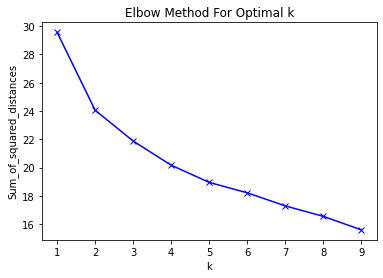

In [14]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, init="k-means++").fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### K-means Algorithm

In [15]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init="k-means++").fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 1, 2, 0, 1, 3, 1, 0], dtype=int32)

In [16]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
venues_sorted.head()

,Cluster Labels,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,"Adelaide, Downtown Toronto, M5H",43.650298,-79.380477,Restaurant,Dessert,GymSprots,LiquorstoresBar,Hotel
1,3,"Agincourt North, Scarborough, M1V",43.808038,-79.266439,Restaurant,Othershop,Dessert,ClothingCosmetics,Grocery
2,1,"Agincourt, Scarborough, M1S",43.794200,-79.262029,Restaurant,ClothingCosmetics,HomeGarden,GymSprots,Othershop
3,1,"Albion Gardens, Etobicoke, M9V",43.739500,-79.559100,ATM,Convenience Store,Medical,Grocery,Othershop
4,2,"Alderwood, Etobicoke, M8W",43.601717,-79.545232,GymSprots,Restaurant,Dessert,Medical,LiquorstoresBar


In [17]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_sorted['Neighborhood Latitude'], venues_sorted['Neighborhood Longitude'], venues_sorted['combined'], venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + '   Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [19]:
venues_sorted.loc[venues_sorted['Cluster Labels']==0.0,:]

,Cluster Labels,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,0,"Bathurst Manor, North York, M3H",43.757640,-79.453793,ClothingCosmetics,Playground,Park,Othershop,Warehouse Store
9,0,"Bedford Park, North York, M5M",43.737388,-79.410925,Othershop,Construction & Landscaping,Currency Exchange,Distribution Center,DrycleanLaundro
18,0,"Caledonia-Fairbanks, York, M6E",43.689026,-79.453512,Park,ClothingCosmetics,Miscellaneous Shop,Salon,Warehouse Store
26,0,"Clarks Corners, Scarborough, M1T",43.796410,-79.297795,Convenience Store,Automotive,Salon,Park,Grocery
42,0,"Downsview, North York, M3K",43.737473,-79.464763,Othershop,Office,Airport,Construction & Landscaping,Park
50,0,"Eringate, Etobicoke, M9C",43.662273,-79.576516,Medical,Park,Warehouse Store,Grocery,Distribution Center
56,0,"Forest Hill SE, Central Toronto, M4V",43.693559,-79.413902,Restaurant,HomeGarden,Bank,Park,Grocery
66,0,"Henry Farm, North York, M2J",43.769509,-79.354296,Intersection,ClothingCosmetics,GymSprots,Park,Warehouse Store
68,0,"Highland Creek, Scarborough, M1C",43.790117,-79.173334,Office,Medical,Construction & Landscaping,Neighborhood,Park
71,0,"Humber Bay, Etobicoke, M8Y",43.640046,-79.495028,Construction & Landscaping,Automotive,HomeGarden,Park,Warehouse Store


In [20]:
venues_sorted.loc[venues_sorted['Cluster Labels']==1.0,:]

,Cluster Labels,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,1,"Agincourt, Scarborough, M1S",43.794200,-79.262029,Restaurant,ClothingCosmetics,HomeGarden,GymSprots,Othershop
3,1,"Albion Gardens, Etobicoke, M9V",43.739500,-79.559100,ATM,Convenience Store,Medical,Grocery,Othershop
6,1,"Bathurst Quay, Downtown Toronto, M5V",43.635791,-79.398329,Dessert,Restaurant,Park,GymSprots,Harbor / Marina
8,1,"Beaumond Heights, Etobicoke, M9V",43.742600,-79.575000,Restaurant,HomeGarden,Othershop,Moving Target,Office
11,1,"Birch Cliff, Scarborough, M1N",43.691805,-79.264494,Dessert,Entertainment,School,Farm,GymSprots
12,1,"Bloordale Gardens, Etobicoke, M9C",43.635317,-79.563674,Convenience Store,Dessert,Othershop,Grocery,Intersection
13,1,"Broadview North (Old East York), East York, M4J",43.683924,-79.356964,Dessert,Medical,GymSprots,Intersection,Park
14,1,"Brockton, West Toronto, M6K",43.650917,-79.440022,Restaurant,Grocery,ArtsMuseum,Bar,Dessert
16,1,"CN Tower, Downtown Toronto, M5V",43.642564,-79.387087,Restaurant,Dessert,Hotel,GymSprots,Aquarium
23,1,"Christie, Downtown Toronto, M6G",43.669542,-79.422564,Dessert,Restaurant,Grocery,GymSprots,Automotive


In [21]:
venues_sorted.loc[venues_sorted['Cluster Labels']==2.0,:]

,Cluster Labels,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,2,"Alderwood, Etobicoke, M8W",43.601717,-79.545232,GymSprots,Restaurant,Dessert,Medical,LiquorstoresBar
55,2,"Forest Hill Road Park, Central Toronto, M5P",43.694677,-79.406680,GymSprots,Trail,Park,Grocery,Distribution Center
69,2,"Hillcrest Village, North York, M2H",43.803762,-79.363452,GymSprots,Restaurant,Pet,Garden,Dessert
76,2,"Humewood-Cedarvale, York, M6C",43.693781,-79.428191,GymSprots,Office,Playground,Trail,Grocery
89,2,"Kingsview Village, Etobicoke, M9R",43.699539,-79.556346,GymSprots,Warehouse Store,Distribution Center,DrycleanLaundro,Entertainment
113,2,"Moore Park, Central Toronto, M4T",43.690388,-79.383297,GymSprots,LiquorstoresBar,Playground,Trail,Park
135,2,"Princess Gardens, Etobicoke, M9B",43.670000,-79.546000,GymSprots,Construction & Landscaping,Salon,Garden,Dessert
156,2,"Silver Hills, North York, M2L",43.761222,-79.368382,GymSprots,Warehouse Store,Distribution Center,DrycleanLaundro,Entertainment
174,2,"Swansea, West Toronto, M6S",43.644940,-79.478313,GymSprots,Park,Bus,Warehouse Store,Garden
210,2,"Woodbine Heights, East York, M4C",43.695344,-79.318389,GymSprots,Salon,Construction & Landscaping,LiquorstoresBar,Bus


In [22]:
venues_sorted.loc[venues_sorted['Cluster Labels']==3.0,:]

,Cluster Labels,combined,Neighborhood Latitude,Neighborhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,"Adelaide, Downtown Toronto, M5H",43.650298,-79.380477,Restaurant,Dessert,GymSprots,LiquorstoresBar,Hotel
1,3,"Agincourt North, Scarborough, M1V",43.808038,-79.266439,Restaurant,Othershop,Dessert,ClothingCosmetics,Grocery
7,3,"Bayview Village, North York, M2K",43.786947,-79.385975,Restaurant,Bank,Dessert,Salon,GymSprots
10,3,"Berczy Park, Downtown Toronto, M5E",43.644771,-79.373306,Restaurant,LiquorstoresBar,Dessert,Grocery,ClothingCosmetics
15,3,"Business reply mail Processing Centre, East To...",43.780400,-79.250500,Restaurant,Dessert,HomeGarden,GymSprots,Books
17,3,"Cabbagetown, Downtown Toronto, M4X",43.664473,-79.366986,Restaurant,Dessert,LiquorstoresBar,Grocery,Medical
19,3,"Canada Post Gateway Processing Centre, Mississ...",43.636966,-79.615819,Restaurant,Dessert,Hotel,Automotive,Construction & Landscaping
20,3,"Cedarbrae, Scarborough, M1H",43.773136,-79.239476,Restaurant,GymSprots,Bank,Grocery,Salon
21,3,"Central Bay Street, Downtown Toronto, M5G",43.657952,-79.387383,Restaurant,Dessert,GymSprots,Books,LiquorstoresBar
22,3,"Chinatown, Downtown Toronto, M5T",43.652924,-79.398032,Restaurant,Dessert,Grocery,LiquorstoresBar,ArtsMuseum
